# Lab 4: Build a Search Agent

In this lab, we'll use the Azure AI Agent Service to create an agent that is able to retrieve information from documents stored in Azure AI Search, a vector database. This pattern is known as retrieval augmented generation or RAG. The documents that we'll be searching are health insurance policies.

#### Part 1: Connect to you Azure AI Search service

Navigate to your Azure AI Foundry project > Management Center > Select 'connected resources' under your project and add your Azure AI Search service using 'Entra ID' authetication.

![Sample Photo](images/project-connected-res.jpg)

![Sample Photo](images/connect-search.jpg)

### Part 2: Create the Azure AI Search Index

We'll start the lab by creating an Azure AI Search index in our search service, which will contain vectorized representations of our health insurance plan documents. The steps shown below to create the AI Search index are from the official Microsoft [documentation](https://learn.microsoft.com/en-us/azure/search/search-get-started-portal-import-vectors?tabs=sample-data-storage%2Cmodel-aoai%2Cconnect-data-storage)

#### Step 1
Inspect the documents in the 'data' folder, which are sourced from [here](https://github.com/luckypamula/azure-ai-agents-labs/tree/main/data). These will be stored in our Azure AI Search index.

#### Step 2
Next, we'll upload the health plan documents to Azure Blob Storage, which Azure AI search connects to.
1. Navigate to the Storage Account you created. 
2. Expand "Data Storage" in the side menu and click on "Containers". 
3. Create a new container named "healthplan"

    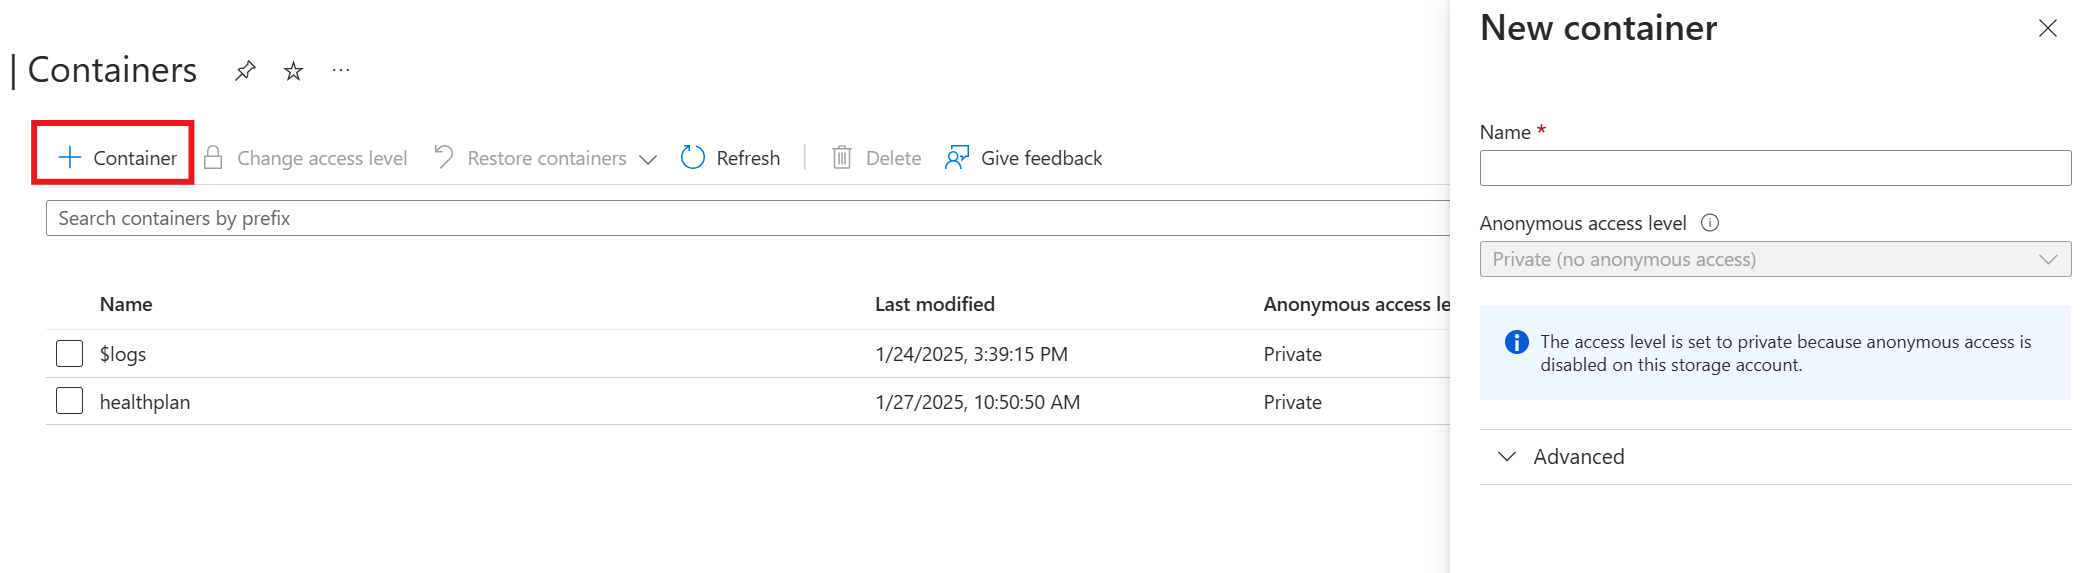
4. Click into the new container and upload the two documents in the 'data' folder.

    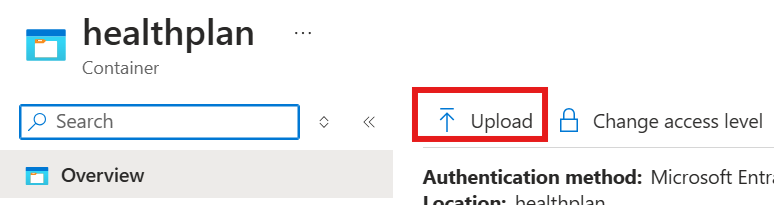

#### Step 3
We need an embedding model in order to convert our documents into vectors that will be stored in Azure AI Search...luckily, we've already deployed a text-embedding-3-large model during the setup in Lab 1!

#### Step 4
Now we're ready to vectorize our documents.
1. Go to your Azure AI Search Service where your text-embedding-3-large model is deployed
2. On the **Overview page**, select **Import and vectorize data**.
3. Select **Azure Blob Storage** as your data source.
4. On the next page, select 'RAG'.
5. On the next page **configure your Azure blob storage** by specifying your subscription, storage account, and the container that contains your healthplan documents 
6. Make sure **Authenticate using managed idenity is checked** and the **Managed identity type** is set to **System-assigned**.

    ![Sample Photo](images/aisearch-blobconnect.jpg)

5. On the **Vectorize your text** page, select **Azure OpenAI** for **Kind**, select your subscription, and select the name of your Azure OpenAI Service.
6. For the **Model deployment** select `text-embedding-3-large`. 
7. The **Authentication type** should be set to **System-assigned identity**. 
8. Select the box next to the acknowledgement.

    ![Sample Photo](images/vectorize-model.jpg)

9. You can hit **Next** for the next two pages. When you get to the **Review and create** page, set **Objects name prefix** to **healthplan-index**. IMPORTANT: if you choose a different name for your index, be sure to update the code cells below with the correct name!
10. Click **Create**. This will start the document indexing process which will vectorize your documents and create an index. NOTE: it may take a few minutes for you index to fully populate with your document chunks. Wait until the process is complete before continuing to part 2.


### Part 3: Create the Search Agent

Now that we've vectorized our health plan documents and created an index, we can create a Search Agent that will retreive information about our health plans from the index.


#### Step 1: Load packages

In [1]:
import os
from dotenv import load_dotenv
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
from azure.ai.agents.models import AzureAISearchToolDefinition, AzureAISearchToolResource, AISearchIndexResource, ToolResources, AgentThreadCreationOptions

load_dotenv()

True

#### Step 2: Connect to your Azure AI Foundry project

In [2]:
# Connecting to our Azure AI Foundry project, which will allow us to use the deployed gpt-4o model
project = AIProjectClient(
    endpoint=os.getenv("AIPROJECT_ENDPOINT"),
    credential=DefaultAzureCredential()
)

#### Step 3: Connect to your Azure AI Search index

In [3]:
# Iterate through the connections in your project and get the connection ID of the Azure AI Search connection.
conn_id = None
for conn in project.connections.list():
    if getattr(conn, "type", None) == "CognitiveSearch":
        conn_id = conn.id
        break

if not conn_id:
    raise ValueError("No Azure Cognitive Search connection found in this project.")

# Define the Azure AI Search tool and its resources using the latest SDK classes, and connect to your AI Search index
ai_search_tool = AzureAISearchToolDefinition()
ai_search_resource = AzureAISearchToolResource(
    index_list=[
        AISearchIndexResource(
            index_connection_id=conn_id,
            index_name="healthplan-index"
        )
    ]
)

# The tool resources are used to define the tools available to the agent
tool_resources = ToolResources(azure_ai_search=ai_search_resource)

#### Step 4: Define the search agent

In [5]:
search_agent = project.agents.create_agent(
    model="gpt-4o",
    name="search-agent",
    instructions="You are a helpful agent that is an expert at searching health plan documents.",
    tools=[ai_search_tool],
    tool_resources=tool_resources
)

#### Step 5: Chat with the search agent

Let's test our search agent by asking it to give us information about the Northwind Standard health plan.

In [6]:
# The name of the health plan we want to search for
plan_name = 'Northwind Standard'

# Create thread options with initial user message and tool resources (use dict for message)
thread_options = AgentThreadCreationOptions(
    messages=[
        {
            "role": "user",
            "content": f"Tell me about the {plan_name} plan."
        }
    ],
    tool_resources=tool_resources
)

# Use create_thread_and_process_run to create the thread, message, and run in one step
run = project.agents.create_thread_and_process_run(
    agent_id=search_agent.id,
    thread=thread_options
)

# Check if the run was successful
if run.status == "failed":
    print(f"Run failed: {run.last_error}")

# Delete the agent when it's done running
project.agents.delete_agent(search_agent.id)

# Fetch all the messages from the thread
messages = project.agents.messages.list(thread_id=run.thread_id)

# Print the last assistant/agent message's text, if any
last_msg = None
for msg in reversed(list(messages)):
    role = getattr(msg, "role", None)
    if role and ("agent" in role.lower() or "assistant" in role.lower()):
        last_msg = msg
        break

if last_msg and getattr(last_msg, "content", None) and isinstance(last_msg.content, list):
    for part in last_msg.content:
        if part.get("type") == "text" and "text" in part and "value" in part["text"]:
            print('Agent:', part["text"]["value"])
            break

Agent: The Northwind Standard plan is a comprehensive health insurance plan that covers medical, vision, and dental services. This plan includes preventive care services and prescription drug coverage. With Northwind Standard, members have access to a variety of in-network providers such as primary care physicians, specialists, hospitals, and pharmacies【3:0†source】.

Key features of the Northwind Standard plan include:

- Coverage for preventive care services like physicals, immunizations, and screenings.
- Coverage for diagnostic tests, treatments, medical consultations, physical therapy, and prescription drugs.
- Inpatient hospital services and certain mental health services are included【3:1†source】.

However, it's important to note that the Northwind Standard plan does not cover emergency services, mental health and substance abuse services, or services from out-of-network providers【3:0†source】【3:2†source】. Additionally, cosmetic services and experimental treatments are not included